In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib notebook

import ast

#To Ignore Warnings in Output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load in the data
business = pd.read_csv('../data/output_csv/business_PA_Philly_clean.csv')
review = pd.read_csv('../data/output_csv/review_PA_Philly_clean.csv')

In [3]:
business.head()

,business_id,name,address,city,postal_code,latitude,longitude,stars,review_count,categories,...,Seafood Markets,Wraps,Shaved Ice,Cupcakes,Greek,Flowers & Gifts,Home & Garden,French,Candy Stores,Chocolatiers & Shops
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,19107,39.955505,-75.155564,4.0,80,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,19106,39.953949,-75.143226,4.0,245,"Sushi Bars, Restaurants, Japanese",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,19147,39.943223,-75.162568,4.5,205,"Korean, Restaurants",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,901 N Delaware Ave,Philadelphia,19123,39.962582,-75.135657,3.5,65,"Eatertainment, Arts & Entertainment, Brewpubs,...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ppFCk9aQkM338Rgwpl2F5A,Wawa,3604 Chestnut St,Philadelphia,19104,39.954573,-75.194894,3.0,56,"Restaurants, Automotive, Delis, Gas Stations, ...",...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
review = review.drop(columns = ['review_id','year'])
review.head()

,user_id,business_id,stars
0,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5
1,Dd1jQj7S-BFGqRbApFzCFw,YtSqYv1Q_pOltsVPSx54SA,5
2,IQsF3Rc6IgCzjVV9DE8KXg,eFvzHawVJofxSnD7TgbZtg,5
3,aFa96pz67TwOFu4Weq5Agg,kq5Ghhh14r-eCxlVmlyd8w,5
4,G0DHgkSsDozqUPWtlxVEMw,oBhJuukGRqPVvYBfTkhuZA,4


In [5]:
business = business[['business_id','name']]

In [6]:
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype


user_u = list(sorted(review.user_id.unique()))
business_u = list(sorted(review.business_id.unique()))

cat_type_user = CategoricalDtype(categories=user_u, ordered=True)
cat_type_business = CategoricalDtype(categories=business_u, ordered=True)

row = review.user_id.astype(cat_type_user).cat.codes
col = review.business_id.astype(cat_type_business).cat.codes

data = review['stars'].tolist()

sparse_matrix = csr_matrix((data, (row, col)), shape=(len(user_u), len(business_u)))


In [7]:
ratings = pd.DataFrame.sparse.from_spmatrix(sparse_matrix,index=user_u, columns=business_u)

In [8]:
ratings.fillna(0, inplace = True)

# SVD

##### With default values

In [9]:
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate

# Step 1: Set up the reader class
#reader = Reader(rating_scale=(1,5))

reader = Reader(line_format='user item rating', rating_scale=(1, 5))


# Step 2: Load the dataframe. Use the merged data from above (not the pivoted data)
data = Dataset.load_from_df(review, reader)

# Use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1765  1.1790  1.1705  1.1779  1.1748  1.1757  0.0030  
MAE (testset)     0.9262  0.9278  0.9226  0.9273  0.9264  0.9261  0.0018  
Fit time          7.98    7.80    7.93    8.14    7.92    7.95    0.11    
Test time         1.04    1.06    1.02    1.16    1.31    1.12    0.11    


{'test_rmse': array([1.17650994, 1.17896288, 1.17052822, 1.17786871, 1.17475294]),
 'test_mae': array([0.92618978, 0.92784156, 0.92263878, 0.92728857, 0.9264376 ]),
 'fit_time': (7.976924896240234,
  7.796505928039551,
  7.927569627761841,
  8.138213396072388,
  7.915435791015625),
 'test_time': (1.041092872619629,
  1.057220458984375,
  1.0198311805725098,
  1.1599464416503906,
  1.307539463043213)}

##### With different parameters

In [10]:
# Build the train set
svd_data = data.build_full_trainset()


In [11]:
# Set up the model and fit the model. Note it will take a few minutes to run
svd = SVD(n_factors = 7, lr_all = 0.01, reg_all = 0.1, biased = True,verbose = True, random_state = 862)
svd.fit(svd_data)


Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [12]:

UID = '--2tyArRmSoyKx5r-FVG0A'
# First we need to obtain the ids of the unvisited restaurants. 
unread_ids = ratings.columns[ratings.loc[UID,:] == 0]

# Now we will loop over the restaurants to extract the predictions
svd_rec = []
for iid in unread_ids:
    svd_rec.append(svd.predict(uid=UID,iid=iid).est)

# Put the result in a pd Series and sort
svd_rec = pd.Series(svd_rec, index = unread_ids).sort_values(ascending=False)


In [13]:
# Recommendations
svd_pp = []
for i in range(10):
    rec_rest_id = svd_rec.index[i]
    svd_pp.append(business[business['business_id'] == rec_rest_id]['name'].values[0])
    print("my number ", i+1, " recommendation is ", business[business['business_id'] == rec_rest_id]['name'].values[0], 
          ", with a predicted rating of", svd_rec.iloc[i])

my number  1  recommendation is  Dan's Fresh Meats , with a predicted rating of 4.880313404372395
my number  2  recommendation is  Taco & Ramen , with a predicted rating of 4.815003967502807
my number  3  recommendation is  El Molino Tortilleria and Restaurant , with a predicted rating of 4.811596904963732
my number  4  recommendation is  Safa Persian Teahouse , with a predicted rating of 4.788428484102862
my number  5  recommendation is  Cafe Mi Quang , with a predicted rating of 4.778626685295353
my number  6  recommendation is  Haggerty Deli , with a predicted rating of 4.778290717152441
my number  7  recommendation is  Philly Foodworks , with a predicted rating of 4.766924330272553
my number  8  recommendation is  Otolith Sustainable Seafood , with a predicted rating of 4.764872132987969
my number  9  recommendation is  Ramona Susan's Bake Shop , with a predicted rating of 4.744659622777604
my number  10  recommendation is  Veghada , with a predicted rating of 4.740254916088864


# Cross Validation

In [14]:
def rmse_vs_factors(algorithm, data):
  """
  Returns: rmse_algorithm i.e. a list of mean RMSE of CV = 5 in cross_validate() for each  factor k in range(1, 26, 1)
  25 values 
  Arg:  i.) algorithm = Matrix factoization algorithm, e.g SVD/NMF/PMF, ii.)  data = surprise.dataset.DatasetAutoFolds
  
  """
  rmse_algorithm = []
  
  for k in range(2, 15, 1):
    algo = algorithm(n_factors = k)
    
    #["test_rmse"] is a numpy array with min accuracy value for each testset
    loss_fce = cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)["test_rmse"].mean() 
    rmse_algorithm.append(loss_fce)
  
  return rmse_algorithm

In [15]:
rmse_svd = rmse_vs_factors(SVD,data)


In [16]:
def plot_rmse(rmse, algorithm):
    plt.figure(num=None, figsize=(11, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(2,1,1)
    plt.plot(rmse)
    plt.xlim(1,15)
    plt.title("{0} Performance: RMSE Against Number of Factors".format(algorithm), size = 20 )
    plt.ylabel("Mean RMSE (cv=5)")
    
    plt.subplot(2,1,2)
    plt.plot(rmse)
    plt.xlim(1,15)
    plt.xticks(np.arange(1, 15, step=2))
    plt.xlabel("{0}(n_factor = k)".format(algorithm))
    plt.ylabel("Mean RMSE (cv=5)")

<IPython.core.display.Javascript object>


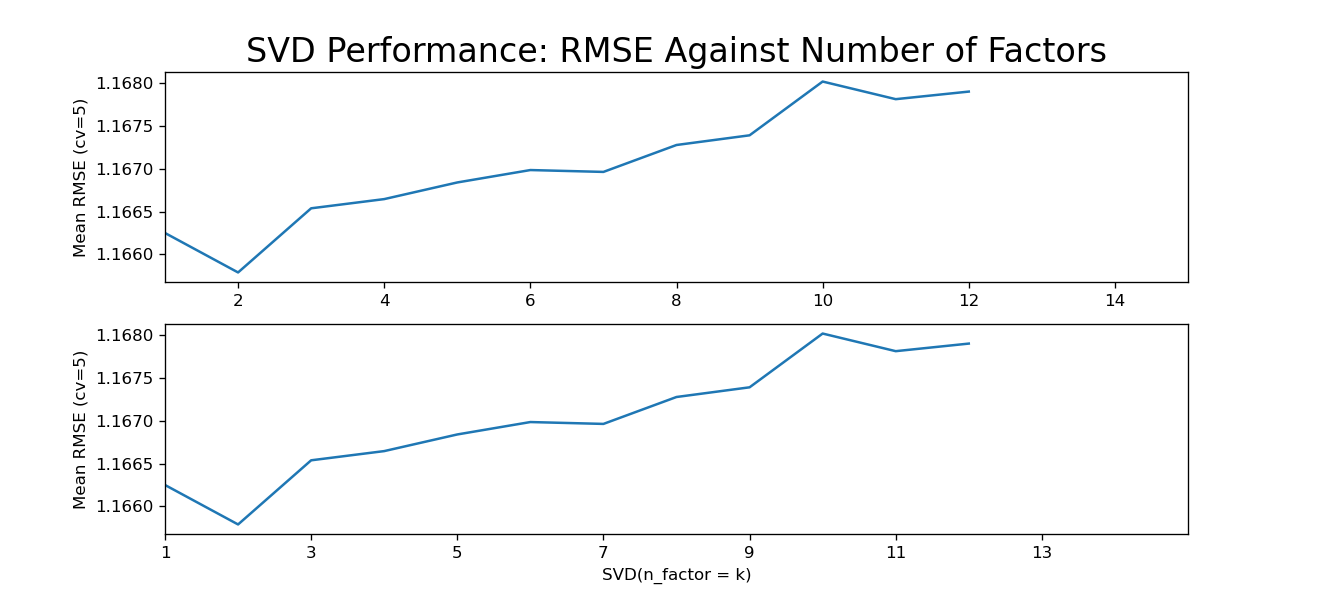

In [17]:
plot_rmse(rmse_svd,"SVD")


# Fitting model with Best K

In [18]:
# Set up the model and fit the model. Note it will take a few minutes to run
svd = SVD(n_factors = 2, lr_all = 0.01, reg_all = 0.1, biased = True,verbose = True, random_state = 862)
svd.fit(svd_data)


Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [19]:

UID = '--2tyArRmSoyKx5r-FVG0A'
# First we need to obtain the ids of the unvisited restaurants. 
unread_ids = ratings.columns[ratings.loc[UID,:] == 0]

# Now we will loop over the restaurants to extract the predictions
svd_rec = []
for iid in unread_ids:
    svd_rec.append(svd.predict(uid=UID,iid=iid).est)

# Put the result in a pd Series and sort
svd_rec = pd.Series(svd_rec, index = unread_ids).sort_values(ascending=False)


In [20]:
# Recommendations
svd_pp = []
for i in range(10):
    rec_rest_id = svd_rec.index[i]
    svd_pp.append(business[business['business_id'] == rec_rest_id]['name'].values[0])
    print("my number ", i+1, " recommendation is ", business[business['business_id'] == rec_rest_id]['name'].values[0], 
          ", with a predicted rating of", svd_rec.iloc[i])

my number  1  recommendation is  Dan's Fresh Meats , with a predicted rating of 4.878191578828749
my number  2  recommendation is  El Molino Tortilleria and Restaurant , with a predicted rating of 4.827514972902009
my number  3  recommendation is  Taco & Ramen , with a predicted rating of 4.794091958606894
my number  4  recommendation is  Veghada , with a predicted rating of 4.785573309096408
my number  5  recommendation is  Safa Persian Teahouse , with a predicted rating of 4.778443413446415
my number  6  recommendation is  Capriotti Bros , with a predicted rating of 4.775990724713141
my number  7  recommendation is  Cafe Mi Quang , with a predicted rating of 4.774560456821716
my number  8  recommendation is  Philly Foodworks , with a predicted rating of 4.7720014728000955
my number  9  recommendation is  Villekebabs and Platters , with a predicted rating of 4.767140806396847
my number  10  recommendation is  Alena’s Cafe , with a predicted rating of 4.762533742505292
